# Training ServeSense Model

##Setup

### Import Packages and Set Constants

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy.interpolate import interp1d
!apt-get update && apt-get -qq install xxd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' do

In [4]:
#DO NOT MODIFY THIS CELL
# Define filenames and set up directory structure
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, "serve_sense")
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "serve_sense_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "serve_sense.tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "serve_sense.cc")

DATASET_DIR =  'dataset'
if not os.path.exists(DATASET_DIR):
  os.mkdir(DATASET_DIR)
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")
!rm -rf sample_data

CHKPT_DIR =  'checkpoints'
if not os.path.exists(CHKPT_DIR):
  os.mkdir(CHKPT_DIR)

## 1.2 Configure Train/Test Split
Choose how to split your dataset for training, validation, and testing.

In [5]:
# TODO - Choose a Train, validation, test Split Pecentage for your dataset
TRAIN_PERCENTAGE = 60
VALIDATION_PERCENTAGE = 20
TEST_PERCENTAGE = 20

## 1.2.2 Load and Organize Dataset by Label
Upload all of your ServeSense JSON files that you created using the web interface. You can select multiple files and upload them all at once.

The system will extract all sessions and organize them by serve type (label).

In [6]:
# Upload your ServeSense JSON files
from google.colab import files
import json

print("Upload your ServeSense JSON files (servesense_*.json)...")
uploaded = files.upload()

# Parse and extract all sessions
all_sessions = []

for filename in uploaded.keys():
    with open(filename, "r") as f:
        data = json.load(f)

    # ServeSense format has "sessions" array
    if "sessions" in data:
        for session in data["sessions"]:
            session["filename"] = filename
            all_sessions.append(session)
    else:
        print(f"Warning: {filename} doesn't have 'sessions' key")

print(f"\nLoaded {len(all_sessions)} total sessions from {len(uploaded)} files")

Upload your ServeSense JSON files (servesense_*.json)...


Saving servesense_2025-12-05 (2).json to servesense_2025-12-05 (2).json
Saving servesense_2025-12-05.json to servesense_2025-12-05.json
Saving servesense_2025-12-05 (3).json to servesense_2025-12-05 (3).json
Saving servesense_2025-12-05 (1).json to servesense_2025-12-05 (1).json
Saving servesense_2025-12-04 (7).json to servesense_2025-12-04 (7).json
Saving servesense_2025-12-04 (4).json to servesense_2025-12-04 (4).json
Saving servesense_2025-12-04 (3).json to servesense_2025-12-04 (3).json
Saving servesense_2025-12-04 (2).json to servesense_2025-12-04 (2).json
Saving servesense_2025-12-04 (1).json to servesense_2025-12-04 (1).json
Saving servesense_2025-12-04.json to servesense_2025-12-04.json

Loaded 286 total sessions from 10 files


In [7]:
# Organize sessions by label (serve type)
# Labels from ServeSense web interface:
# - "good-serve": Good Serve
# - "jerky-motion": Jerky Motion
# - "short-swing": Short Swing
# - "lacks-pronation": Lacks Pronation

from collections import defaultdict

sessions_by_label = defaultdict(list)

for session in all_sessions:
    # Get the label from session metadata
    if "label" in session:
        label = session["label"]
        sessions_by_label[label].append(session)
    else:
        # If no label, use "unlabeled" category
        sessions_by_label["unlabeled"].append(session)
        print(f"Warning: Session {session.get('sessionId', 'unknown')} has no label")

# Print summary
print(f"\n{'='*50}")
print(f"Dataset Summary:")
print(f"{'='*50}")
print(f"Total sessions: {len(all_sessions)}")
print(f"Number of unique labels: {len(sessions_by_label)}")
print(f"\nSessions per label:")
for label, sessions in sorted(sessions_by_label.items()):
    avg_samples = sum(len(s['samples']) for s in sessions) / len(sessions)
    print(f"  {label:20s}: {len(sessions):3d} sessions (avg {avg_samples:.0f} samples/session)")
print(f"{'='*50}")


Dataset Summary:
Total sessions: 286
Number of unique labels: 4

Sessions per label:
  good-serve          :  46 sessions (avg 164 samples/session)
  jerky-motion        :  84 sessions (avg 155 samples/session)
  lacks-pronation     : 104 sessions (avg 169 samples/session)
  short-swing         :  52 sessions (avg 102 samples/session)


In [8]:
# Number of unique serve types in dataset
NUM_LABELS = len(sessions_by_label)
print(f"Number of unique labels: {NUM_LABELS}")
print(f"Labels: {sorted(sessions_by_label.keys())}")

Number of unique labels: 4
Labels: ['good-serve', 'jerky-motion', 'lacks-pronation', 'short-swing']


## 1.3 Visualize Data



In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to visualize tennis serve data
def plot_serve(session):
    """Plot acceleration and gyroscope data for a tennis serve session"""
    samples = session['samples']

    # Extract data from samples
    time = np.arange(len(samples)) * 0.025  # 25ms sampling period = 0.025s
    ax = [s['ax'] for s in samples]
    ay = [s['ay'] for s in samples]
    az = [s['az'] for s in samples]
    gx = [s['gx'] for s in samples]
    gy = [s['gy'] for s in samples]
    gz = [s['gz'] for s in samples]

    # Get session info
    session_id = session.get('sessionId') or session.get('session_id') or 'unknown'
    label = session.get('label', 'unknown')

    # Create figure with 2 subplots (matching web app layout)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot acceleration (top graph)
    ax1.plot(time, ax, 'r-', label='Accel X', linewidth=2)
    ax1.plot(time, ay, 'g-', label='Accel Y', linewidth=2)
    ax1.plot(time, az, 'b-', label='Accel Z', linewidth=2)
    ax1.set_xlabel('Time (seconds)', fontsize=12)
    ax1.set_ylabel('Acceleration (g)', fontsize=12)
    ax1.set_title(f"Label: {label} | Session {session_id}", fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.margins(y=0.1)  # Add 10% padding to y-axis

    # Plot gyroscope (bottom graph)
    ax2.plot(time, gx, 'r-', label='Gyro X', linewidth=2)
    ax2.plot(time, gy, 'g-', label='Gyro Y', linewidth=2)
    ax2.plot(time, gz, 'b-', label='Gyro Z', linewidth=2)
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_ylabel('Angular Velocity (°/s)', fontsize=12)
    ax2.set_title('Gyroscope Data', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.margins(y=0.1)  # Add 10% padding to y-axis

    plt.tight_layout()
    plt.show()

    print(f"Session {session_id}: {len(samples)} samples, duration: {time[-1]:.2f}s")

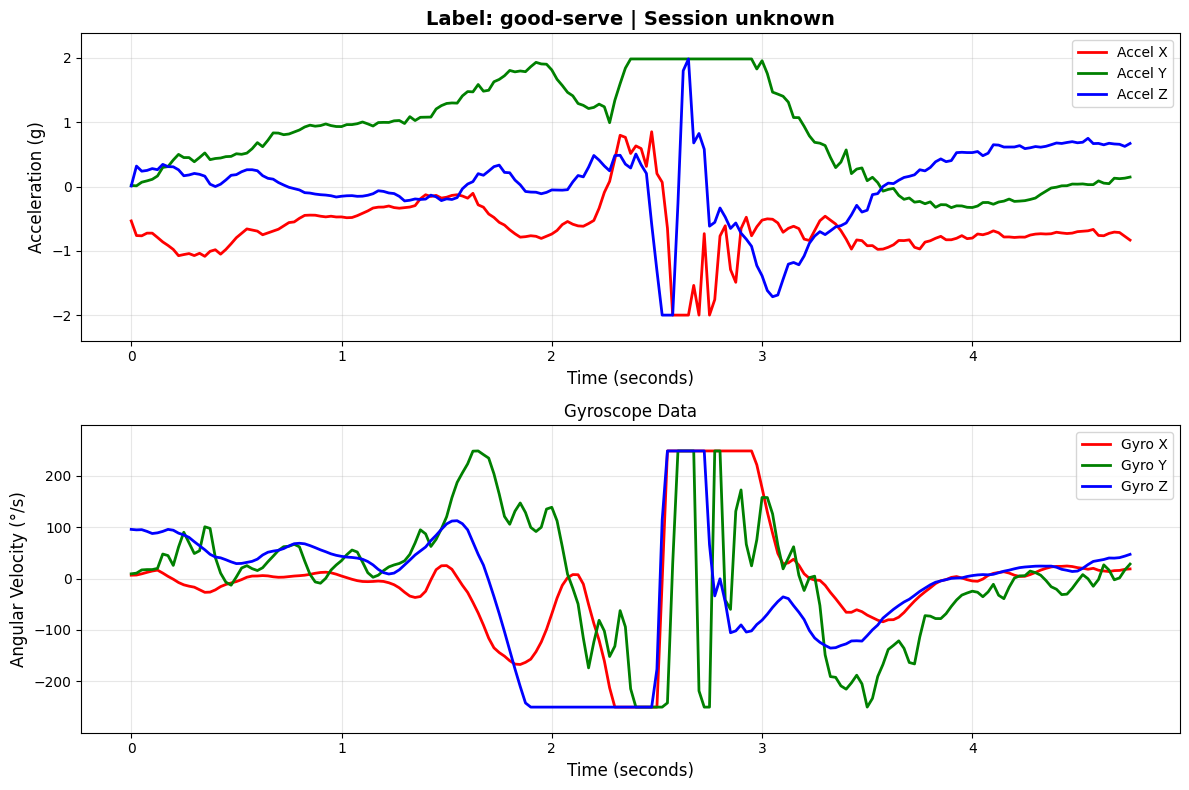

Session unknown: 191 samples, duration: 4.75s


In [23]:
# Visualize first good-serve session
plot_serve(sessions_by_label['good-serve'][0])

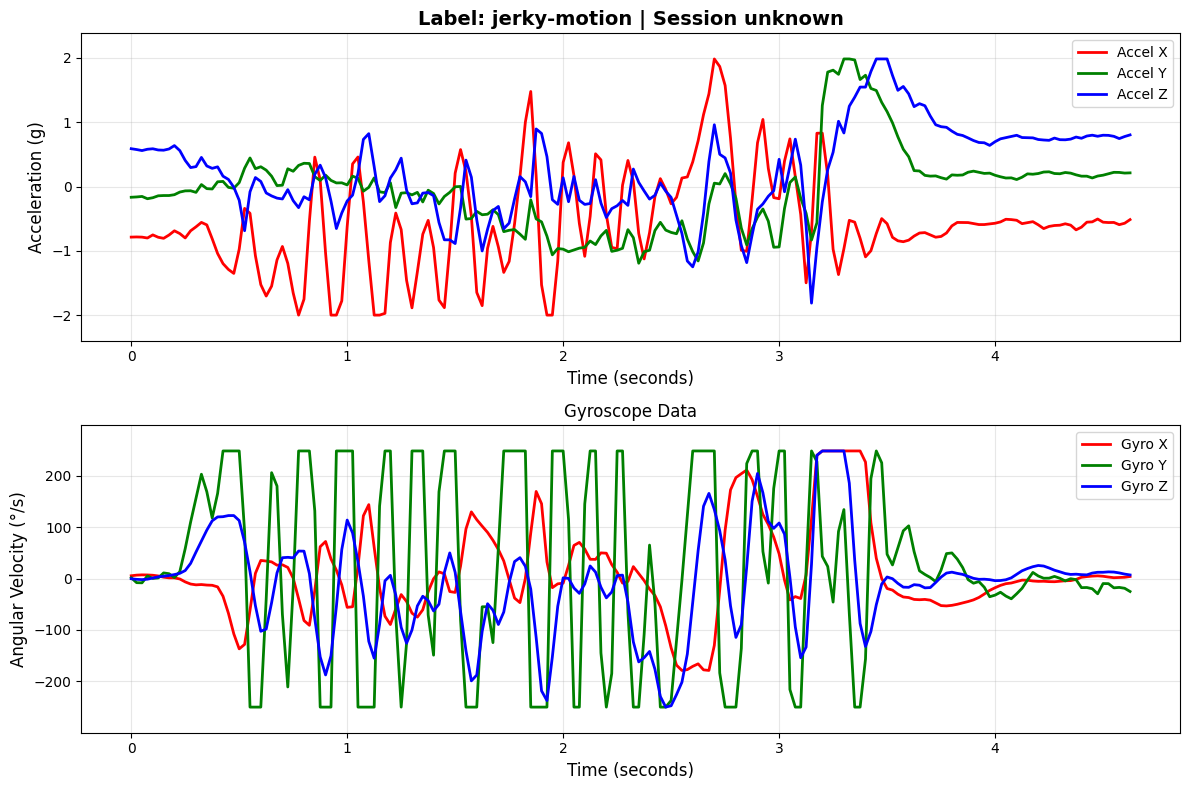

Session unknown: 186 samples, duration: 4.62s


In [24]:
# Visualize first jerky-motion session
plot_serve(sessions_by_label['jerky-motion'][0])

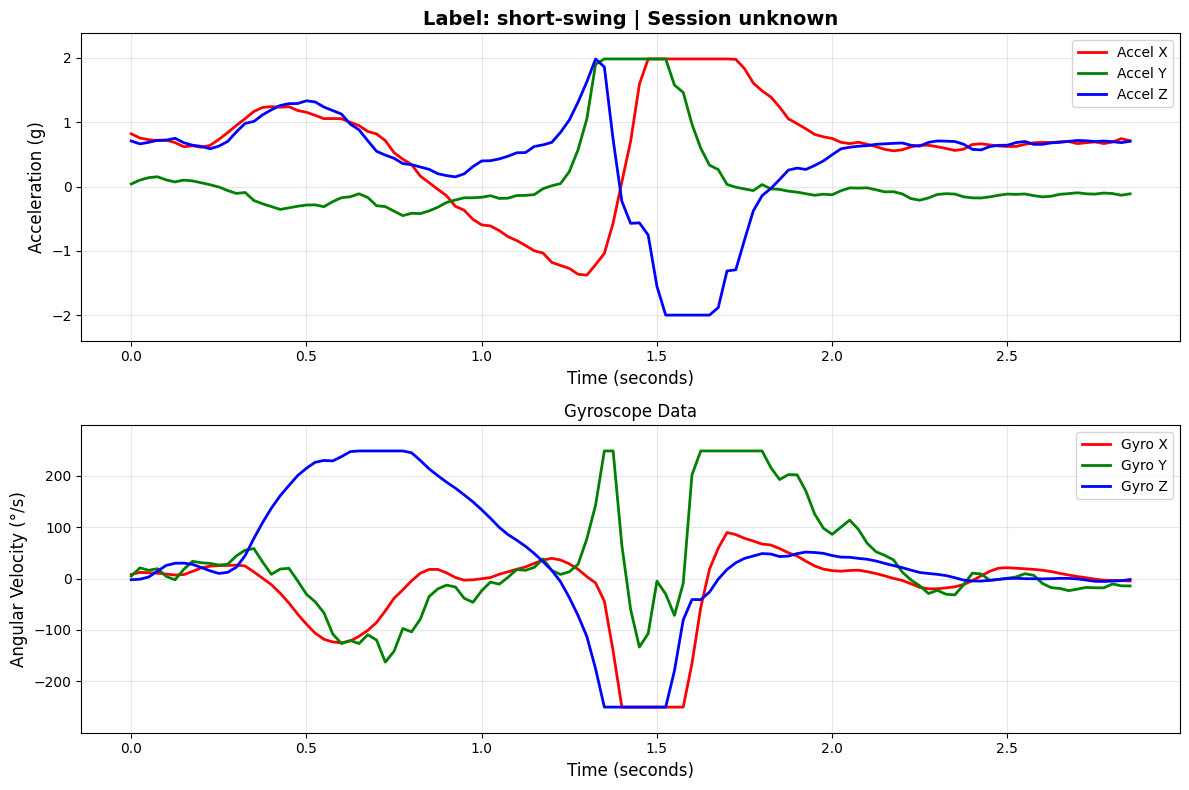

Session unknown: 115 samples, duration: 2.85s


In [25]:
# Visualize first short-swing session
plot_serve(sessions_by_label['short-swing'][0])

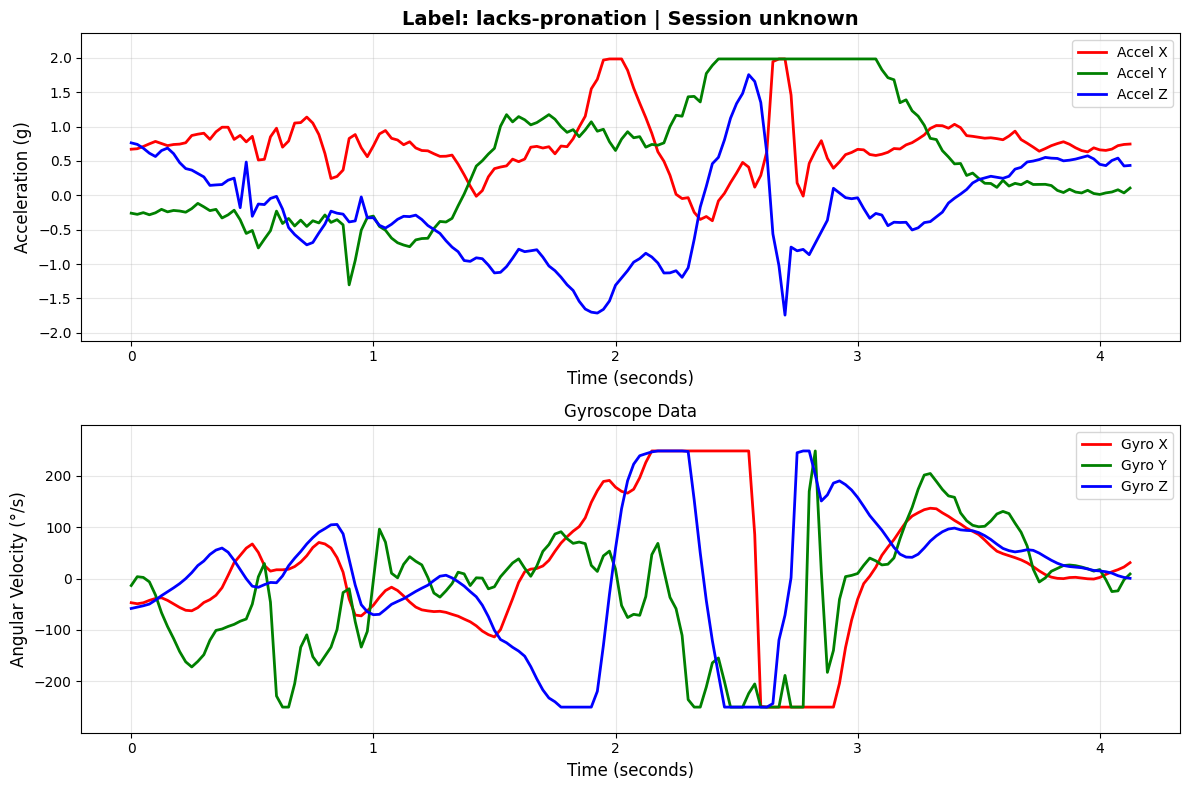

Session unknown: 166 samples, duration: 4.12s


In [26]:
# Visualize first lacks-pronation session
plot_serve(sessions_by_label['lacks-pronation'][0])

## 1.4 Preprocess Dataset

Next we'll preprocess the dataset to prepare it for training.


In [37]:
import numpy as np

# Configuration
SEQUENCE_LENGTH = 160  # 160 samples * 25ms = 4 seconds

def preprocess_session(session, sequence_length=SEQUENCE_LENGTH):
    """
    Convert a session into a fixed-length numpy array
    - Truncates if too long
    - Pads with zeros if too short
    """
    samples = session['samples']

    # Extract the 6 IMU features: ax, ay, az, gx, gy, gz
    data = []
    for sample in samples:
        data.append([
            sample['ax'], sample['ay'], sample['az'],
            sample['gx'], sample['gy'], sample['gz']
        ])

    data = np.array(data)

    # Truncate or pad to sequence_length
    if len(data) > sequence_length:
        data = data[:sequence_length]  # Truncate
    elif len(data) < sequence_length:
        # Pad with zeros
        padding = np.zeros((sequence_length - len(data), 6))
        data = np.vstack([data, padding])

    return data

# Test preprocessing
test_session = sessions_by_label['good-serve'][0]
preprocessed = preprocess_session(test_session)
print(f"Original samples: {len(test_session['samples'])}")
print(f"Preprocessed shape: {preprocessed.shape}")  # Should be (160, 6)
print(f"Sample data:\n{preprocessed[:3]}")

Original samples: 191
Preprocessed shape: (160, 6)
Sample data:
[[-5.34912109e-01  1.66015625e-02  8.05664062e-03  6.45038176e+00
   9.16793919e+00  9.55801544e+01]
 [-7.62695312e-01  1.07421875e-02  3.17871094e-01  6.78625965e+00
   1.04580154e+01  9.46564865e+01]
 [-7.66601562e-01  6.71386719e-02  2.38769531e-01  9.12977123e+00
   1.67251911e+01  9.50534363e+01]]


In [38]:
# Create label mapping
label_names = sorted(sessions_by_label.keys())
label_to_int = {label: i for i, label in enumerate(label_names)}
int_to_label = {i: label for label, i in label_to_int.items()}

print("Label mapping:")
for label, idx in label_to_int.items():
    print(f"  {idx}: {label}")

# Preprocess all sessions (variable length)
X = []  # List of arrays (each with different length)
y = []  # Labels

for label, sessions in sessions_by_label.items():
    for session in sessions:
        preprocessed = preprocess_session(session)
        X.append(preprocessed)
        y.append(label_to_int[label])

y = np.array(y)

print(f"\nDataset created:")
print(f"  Total sessions: {len(X)}")
print(f"  Session lengths: min={min(len(x) for x in X)}, max={max(len(x) for x in X)}, avg={np.mean([len(x) for x in X]):.1f}")
print(f"\nSessions per label:")
for label, idx in label_to_int.items():
    count = np.sum(y == idx)
    print(f"  {label}: {count} sessions")

Label mapping:
  0: good-serve
  1: jerky-motion
  2: lacks-pronation
  3: short-swing

Dataset created:
  Total sessions: 286
  Session lengths: min=160, max=160, avg=160.0

Sessions per label:
  good-serve: 46 sessions
  jerky-motion: 84 sessions
  lacks-pronation: 104 sessions
  short-swing: 52 sessions


Take the dataset and shuffle it into the Training/Validation/Test splits

In [39]:
from sklearn.model_selection import train_test_split

# Combine X and y for shuffling
# X is a list of variable-length arrays, y is label indices
indices = np.arange(len(X))
np.random.shuffle(indices)

X_shuffled = [X[i] for i in indices]
y_shuffled = y[indices]

# Calculate split sizes
test_count = int(len(X_shuffled) * TEST_PERCENTAGE / 100)
validation_count = int(len(X_shuffled) * VALIDATION_PERCENTAGE / 100)

# Split into test, validation, train
X_test = X_shuffled[:test_count]
y_test = y_shuffled[:test_count]

X_val = X_shuffled[test_count:test_count + validation_count]
y_val = y_shuffled[test_count:test_count + validation_count]

X_train = X_shuffled[test_count + validation_count:]
y_train = y_shuffled[test_count + validation_count:]

print(f"Dataset split:")
print(f"Train: {len(X_train)} sessions ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val)} sessions ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} sessions ({len(X_test)/len(X)*100:.1f}%)")

Dataset split:
Train: 172 sessions (60.1%)
Validation: 57 sessions (19.9%)
Test: 57 sessions (19.9%)


## 1.5 Define Your Models

We'll be creating three different neural network architectures and compare their performance:
1. **1D CNN** - Extracts spatial features from IMU signals
2. **LSTM** - Learns temporal dependencies in motion sequences  
3. **Hybrid CNN-LSTM** - Combines both approaches for best results

All models classify tennis serves into 4 categories: good-serve, jerky-motion, lacks-pronation, short-swing

In [54]:
from tensorflow import keras
from tensorflow.keras import layers

# Model configuration
SEQUENCE_LENGTH = 160  # Fixed length (160 samples * 25ms = 4 seconds)
NUM_FEATURES = 6  # ax, ay, az, gx, gy, gz
NUM_CLASSES = len(label_to_int)

print(f"Input shape: ({SEQUENCE_LENGTH}, {NUM_FEATURES})")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {list(label_to_int.keys())}")

Input shape: (160, 6)
Number of classes: 4
Classes: ['good-serve', 'jerky-motion', 'lacks-pronation', 'short-swing']


In [55]:
#1-D CNN Model
def make_1dcnn_model(sequence_length, num_features, num_classes):
    """1D CNN model for IMU time-series classification"""
    inputs = keras.Input(shape=(sequence_length, num_features))

    # 1D Convolutional layers to extract features
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers for classification
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="1D_CNN")
    return model

# Create 1D CNN model
model_cnn = make_1dcnn_model(SEQUENCE_LENGTH, NUM_FEATURES, NUM_CLASSES)
print("\n1D CNN Model:")
model_cnn.summary()


1D CNN Model:


Model: "1D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 160, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 80, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 80, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 40, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,036 (156.39 KB)

 Trainable params: 40,036 (156.39 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
#LSTM Model
def make_lstm_model(sequence_length, num_features, num_classes):
    """LSTM model for IMU time-series classification"""
    inputs = keras.Input(shape=(sequence_length, num_features))

    # LSTM layers to learn temporal patterns
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.3)(x)

    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)

    # Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM")
    return model

# Create LSTM model
model_lstm = make_lstm_model(SEQUENCE_LENGTH, NUM_FEATURES, NUM_CLASSES)
print("\nLSTM Model:")
model_lstm.summary()


LSTM Model:


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 160, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 160, 64)        │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 160, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,620 (217.27 KB)

 Trainable params: 55,620 (217.27 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
#Hybrid CNN-LSTM Model

def make_cnn_lstm_model(sequence_length, num_features, num_classes):
    """Hybrid CNN-LSTM model - best of both worlds"""
    inputs = keras.Input(shape=(sequence_length, num_features))

    # CNN layers to extract spatial features
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    # LSTM layers to learn temporal dependencies
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.LSTM(32, return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)

    # Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="CNN_LSTM_Hybrid")
    return model

# Create hybrid model
model_hybrid = make_cnn_lstm_model(SEQUENCE_LENGTH, NUM_FEATURES, NUM_CLASSES)
print("\nHybrid CNN-LSTM Model:")
model_hybrid.summary()


Hybrid CNN-LSTM Model:


Model: "CNN_LSTM_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 160, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 160, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 80, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 80, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 40, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,628 (213.39 KB)

 Trainable params: 54,628 (213.39 KB)

 Non-trainable params: 0 (0.00 B)

###Task: 1.5.2 Visualize Model
Paste your model into the final document.

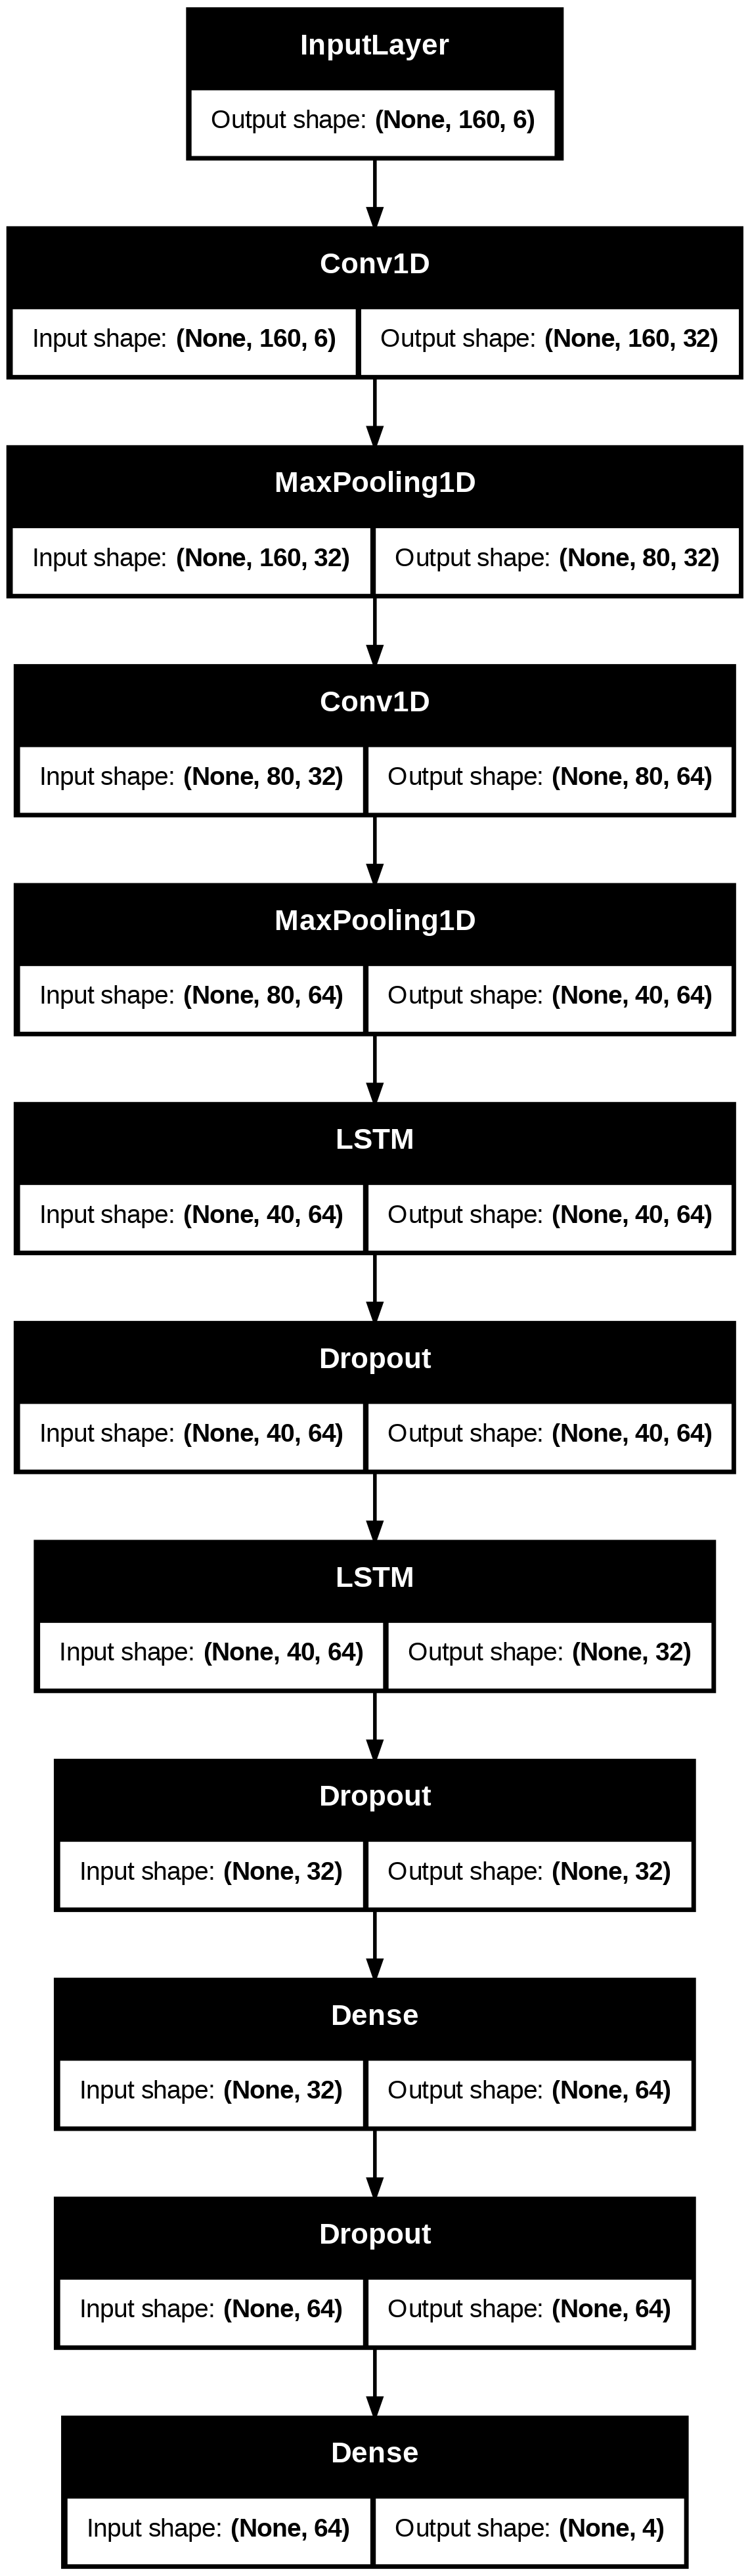

In [58]:
# View the model layers as a diagram
keras.utils.plot_model(model_hybrid, show_shapes=True)

## 1.6 Train Your Models

Now that we have preprocessed data and defined our models, it's time to train them! We'll train each model separately and compare their performance.

In [59]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Convert X from list to numpy array (all sessions should be (160, 6) now)
X_train_array = np.array(X_train)
X_val_array = np.array(X_val)
X_test_array = np.array(X_test)

# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

print("Training data shapes:")
print(f"  X_train: {X_train_array.shape}")
print(f"  y_train: {y_train_cat.shape}")
print(f"  X_val: {X_val_array.shape}")
print(f"  y_val: {y_val_cat.shape}")
print(f"  X_test: {X_test_array.shape}")
print(f"  y_test: {y_test_cat.shape}")

Training data shapes:
  X_train: (172, 160, 6)
  y_train: (172, 4)
  X_val: (57, 160, 6)
  y_val: (57, 4)
  X_test: (57, 160, 6)
  y_test: (57, 4)


In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile CNN model
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

# Train CNN model
print("Training 1D CNN Model...")
history_cnn = model_cnn.fit(
    X_train_array, y_train_cat,
    validation_data=(X_val_array, y_val_cat),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test_array, y_test_cat)
print(f"\n1D CNN Test Accuracy: {test_acc_cnn:.4f}")
print(f"1D CNN Test Loss: {test_loss_cnn:.4f}")

Training 1D CNN Model...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - accuracy: 0.3166 - loss: 14.0433 - val_accuracy: 0.3158 - val_loss: 1.6619 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3299 - loss: 3.9291 - val_accuracy: 0.1930 - val_loss: 1.5161 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4811 - loss: 1.6870 - val_accuracy: 0.7719 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5646 - loss: 1.1267 - val_accuracy: 0.8596 - val_loss: 0.6314 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6487 - loss: 0.9092 - val_accuracy: 0.9825 - val_loss: 0.4851 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6555 - loss: 0.7127 - val_accuracy: 1.0000 - val_loss: 0.2817 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7867

In [61]:
# Compile LSTM model
model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train LSTM model
print("Training LSTM Model...")
history_lstm = model_lstm.fit(
    X_train_array, y_train_cat,
    validation_data=(X_val_array, y_val_cat),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test_array, y_test_cat)
print(f"\nLSTM Test Accuracy: {test_acc_lstm:.4f}")
print(f"LSTM Test Loss: {test_loss_lstm:.4f}")

Training LSTM Model...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.3080 - loss: 1.3542 - val_accuracy: 0.4211 - val_loss: 1.2543 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4058 - loss: 1.2261 - val_accuracy: 0.4211 - val_loss: 1.1267 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5008 - loss: 1.1041 - val_accuracy: 0.6140 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6557 - loss: 0.9939 - val_accuracy: 0.6667 - val_loss: 0.8886 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7052 - loss: 0.8746 - val_accuracy: 0.7544 - val_loss: 0.7728 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7833 - loss: 0.7040 - val_accuracy: 0.7018 - val_loss: 0.7992 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8041 -

In [63]:
# Compile Hybrid model
model_hybrid.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Hybrid model
print("Training Hybrid CNN-LSTM Model...")
history_hybrid = model_hybrid.fit(
    X_train_array, y_train_cat,
    validation_data=(X_val_array, y_val_cat),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss_hybrid, test_acc_hybrid = model_hybrid.evaluate(X_test_array, y_test_cat)
print(f"\nHybrid Test Accuracy: {test_acc_hybrid:.4f}")
print(f"Hybrid Test Loss: {test_loss_hybrid:.4f}")

Training Hybrid CNN-LSTM Model...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9553 - loss: 0.1519 - val_accuracy: 0.9649 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9946 - loss: 0.0778 - val_accuracy: 0.9474 - val_loss: 0.3056 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9717 - loss: 0.1265 - val_accuracy: 0.9649 - val_loss: 0.2937 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9866 - loss: 0.0575 - val_accuracy: 0.9474 - val_loss: 0.3260 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9813 - loss: 0.0577 - val_accuracy: 0.9123 - val_loss: 0.5010 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9861 - loss: 0.0785 - val_accuracy: 0.9649 - val_loss: 0.2992 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accurac

Test set distribution:
  good-serve: 10 samples
  jerky-motion: 14 samples
  lacks-pronation: 19 samples
  short-swing: 14 samples
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

Confusion Matrix:
[[ 9  1  0  0]
 [ 0 14  0  0]
 [ 0  0 19  0]
 [ 0  0  0 14]]

Detailed Report:
                 precision    recall  f1-score   support

     good-serve       1.00      0.90      0.95        10
   jerky-motion       0.93      1.00      0.97        14
lacks-pronation       1.00      1.00      1.00        19
    short-swing       1.00      1.00      1.00        14

       accuracy                           0.98        57
      macro avg       0.98      0.97      0.98        57
   weighted avg       0.98      0.98      0.98        57



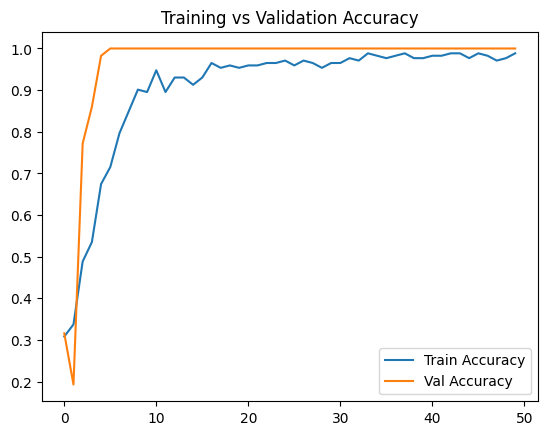

In [64]:
# Check class distribution in test set
print("Test set distribution:")
for i, label in int_to_label.items():
    count = np.sum(y_test == i)
    print(f"  {label}: {count} samples")

# Get predictions and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model_cnn.predict(X_test_array)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

print("\nDetailed Report:")
print(classification_report(y_test, y_pred_classes, target_names=list(int_to_label.values())))

# Check training vs validation accuracy
import matplotlib.pyplot as plt
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [66]:
import os
os.makedirs("models", exist_ok=True)

# Save the CNN model (best performer)
model_cnn.save("models/serve_sense_cnn.keras")

# Also export as SavedModel format (for TensorFlow Lite conversion)
model_cnn.export("models/serve_sense_cnn_saved_model")

print("Model saved successfully!")
print("  Keras format: models/serve_sense_cnn.keras")
print("  SavedModel format: models/serve_sense_cnn_saved_model/")

Saved artifact at 'models/serve_sense_cnn_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 6), dtype=tf.float32, name='keras_tensor_84')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132643294753424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643294754384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643294754000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643294756304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643294754768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293528336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293528144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293529872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293529488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293530448: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [67]:
tf.__version__

'2.19.0'

In [68]:
keras.__version__

'3.10.0'

In [70]:
import os, glob, pathlib, sys
print("CWD:", os.getcwd())
print("Exists(models):", os.path.isdir("models"))
print("Files under models/:")
for p in glob.glob("models/**", recursive=True):
    print("  ", p)


CWD: /content
Exists(models): True
Files under models/:
   models/
   models/serve_sense_cnn_saved_model
   models/serve_sense_cnn_saved_model/saved_model.pb
   models/serve_sense_cnn_saved_model/assets
   models/serve_sense_cnn_saved_model/fingerprint.pb
   models/serve_sense_cnn_saved_model/variables
   models/serve_sense_cnn_saved_model/variables/variables.index
   models/serve_sense_cnn_saved_model/variables/variables.data-00000-of-00001
   models/serve_sense_cnn.keras


In [72]:
import tensorflow as tf

# Point to our SavedModel directory
SAVED_MODEL_DIR = "models/serve_sense_cnn_saved_model"
assert os.path.exists(os.path.join(SAVED_MODEL_DIR, "saved_model.pb")), \
    f"Not a SavedModel: {SAVED_MODEL_DIR}"

# Load the saved model
m = tf.saved_model.load(SAVED_MODEL_DIR)

# Inspect serving signature
print("Serving signature:")
print(m.signatures['serving_default'])

Serving signature:
ConcreteFunction Input Parameters:
  keras_tensor_84 (KEYWORD_ONLY): TensorSpec(shape=(None, 160, 6), dtype=tf.float32, name='keras_tensor_84')
Output Type:
  Dict[['output_0', TensorSpec(shape=(None, 4), dtype=tf.float32, name='output_0')]]
Captures:
  132643426574288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643426569104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643426567568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643426580048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643426581968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643426568528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293535440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293535824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293536400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293541008: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [74]:
# save the model file
model_cnn.export("models/serve_sense_cnn_saved_model")

Saved artifact at 'models/serve_sense_cnn_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 6), dtype=tf.float32, name='keras_tensor_84')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132643294753424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643294754384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643294754000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643294756304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643294754768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293528336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293528144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293529872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293529488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132643293530448: TensorSpec(shape=(), dtype=tf.resource, name=None)


## 2 TensorFlow Lite Conversion

Now we'll convert our CNN model to TensorFlow Lite format with int8 quantization for deployment on the XIAO ESP32S3.

## 2.1 Generate TensorFlow Lite Model

Convert the SavedModel to TensorFlow Lite with full integer quantization. We'll use int8 for both inputs and outputs to match the ESP32-S3 requirements.

### Task: 2.1.1 Define your Quantizer
For this cell, we want you to:
1. Define the converter using the TFLiteConverter API for our saved model (name is essential)
2. Convert the model using that converter's functions
3. Set optimization flag for Integer Quantization
4. Define the input and output inference types

Please use int8:

*   converter.inference_input_type = tf.int8
*   converter.inference_output_type = tf.int8

This ensures the Colab-produced model matches the ESP32-S3 codebase (which uses int8 kernels, not uint8).


In [75]:
# Create TFLite converter from SavedModel
SAVED_MODEL_DIR = "models/serve_sense_cnn_saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)

# Set optimization for full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define representative dataset for quantization
def representative_dataset():
    # Use training data samples for calibration
    for i in range(min(100, len(X_train_array))):
        # Yield single sample with batch dimension
        yield [X_train_array[i:i+1].astype('float32')]

converter.representative_dataset = representative_dataset

# Set input/output to int8 (required for ESP32-S3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model
tflite_model_quant = converter.convert()

# Save quantized model
QUANT_TFL_MODEL_FILE = "models/serve_sense_cnn_quantized.tflite"
with open(QUANT_TFL_MODEL_FILE, "wb") as f:
    f.write(tflite_model_quant)

print(f"Quantized TFLite model saved: {QUANT_TFL_MODEL_FILE}")
print(f"Model size: {len(tflite_model_quant) / 1024:.2f} KB")

Quantized TFLite model saved: models/serve_sense_cnn_quantized.tflite
Model size: 54.08 KB


###Task: 2.1.2 Compare model sizes
Compare the sizes of the Tensorflow, TensorFlow Lite and Quantized TensorFlow Lite models.

Mention the size of your model using the section number.

In [82]:

def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size("models/serve_sense_cnn_saved_model")
size_no_quant_tflite = os.path.getsize("models/serve_sense_cnn.keras")
size_tflite = os.path.getsize("models/serve_sense_cnn_quantized.tflite")

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,400579 bytes,
TensorFlow Lite,531848 bytes,(reduced by -131269 bytes)
TensorFlow Lite Quantized,55376 bytes,(reduced by 476472 bytes)


## 2.2 Test your TensorFlow Lite Models

Lets now test out the TFLite models (quantized and unquantized) on the test dataset. We'll print out any gesture we get wrong as well as the percentage of known gestures correct as well as the number of gestures that were marked as unknown.

###Task: 2.2.1 Quantized Model test
We need you define the interpreter which we have done multiple times over the previous assignments. Also predict the label index and score.

In [ ]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  ### ENTER CODE BELOW
  interpreter = tf.lite.Interpreter(model_content = tflite_model)
  interpreter.allocate_tensors()

  #ENTER CODE ABOVE

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  # Make note of the variable names in the return statement below.
  # Predict  the label index and the score
  ### ENTER CODE BELOW

  predicted_label_index = np.argmax(pred)
  predicted_score = 100
  predicted_score = np.max(pred)



  ### ENTER CODE ABOVE

  return (predicted_label_index, predicted_score)

## 2.2 Test Quantized Model

Test the quantized TFLite model on our test dataset to verify accuracy after quantization.

In [83]:
def predict_tflite(tflite_model, session_data):
    """
    Run inference on a single session using TFLite interpreter
    session_data: numpy array of shape (160, 6)
    """
    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Prepare input data
    # Add batch dimension: (160, 6) -> (1, 160, 6)
    input_data = np.expand_dims(session_data, axis=0).astype(np.float32)

    # Quantize the input if required (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        input_data = input_data / input_scale + input_zero_point
        input_data = input_data.astype(input_details["dtype"])

    # Run inference
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details["index"])[0]

    # Dequantize the output if required (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        output_data = output_data.astype(np.float32)
        output_data = (output_data - output_zero_point) * output_scale

    # Return predicted class index and confidence scores
    pred_class = np.argmax(output_data)
    confidence = output_data[pred_class]

    return pred_class, output_data

First test the float model.

In [86]:
# Test quantized model on test set
correct_count = 0
wrong_count = 0

print("Testing quantized TFLite model on test set...")
print(f"Total test samples: {len(X_test_array)}\n")

for i in range(len(X_test_array)):
    true_label = y_test[i]
    pred_class, scores = predict_tflite(tflite_model_quant, X_test_array[i])

    if pred_class == true_label:
        correct_count += 1
    else:
        wrong_count += 1
        print(f"[Mismatch] Expected: {int_to_label[true_label]}, Predicted: {int_to_label[pred_class]}, Confidence: {scores[pred_class]:.3f}")

# Calculate accuracy
accuracy = (correct_count / (correct_count + wrong_count)) * 100

print(f"\n{'='*60}")
print(f"Quantized TFLite Model Test Results:")
print(f"{'='*60}")
print(f"Correct predictions: {correct_count}")
print(f"Wrong predictions: {wrong_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"{'='*60}")

# Compare with original model
print(f"\nOriginal CNN Test Accuracy: {test_acc_cnn*100:.2f}%")
print(f"Quantized TFLite Accuracy: {accuracy:.2f}%")
print(f"Accuracy loss from quantization: {(test_acc_cnn*100 - accuracy):.2f}%")

Testing quantized TFLite model on test set...
Total test samples: 57

[Mismatch] Expected: good-serve, Predicted: jerky-motion, Confidence: 0.355

Quantized TFLite Model Test Results:
Correct predictions: 56
Wrong predictions: 1
Accuracy: 98.25%

Original CNN Test Accuracy: 98.25%
Quantized TFLite Accuracy: 98.25%
Accuracy loss from quantization: 0.00%


##2.3 Generate a TensorFlow Lite for Microcontrollers Model
DO NOT MODIFY THE FOLLOWING CELLS

To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we simply need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [89]:
# Convert to a C source file using xxd tool
QUANT_TFL_MODEL_FILE = "models/serve_sense_cnn_quantized.tflite"
TFL_CC_MODEL_FILE = "models/serve_sense_model_data.cc"

# Run xxd command to convert .tflite to .cc
!xxd -i {QUANT_TFL_MODEL_FILE} > {TFL_CC_MODEL_FILE}

# Update variable names to be more descriptive
REPLACE_TEXT = QUANT_TFL_MODEL_FILE.replace('/', '_').replace('.', '_')
!sed -i 's/{REPLACE_TEXT}/g_serve_sense_model_data/g' {TFL_CC_MODEL_FILE}

print(f"✅ C source file created: {TFL_CC_MODEL_FILE}")
print(f"Variable name: g_serve_sense_model_data")

✅ C source file created: models/serve_sense_model_data.cc
Variable name: g_serve_sense_model_data


That's it! You've successfully converted your TensorFlow Lite model into a TensorFlow Lite for Microcontrollers model! Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE!

In [90]:
# Print the C source file contents
!cat {TFL_CC_MODEL_FILE}
# !tail {TFL_CC_MODEL_FILENAME} # run this command to just see the end of the file (aka the size)

unsigned char g_serve_sense_model_data[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 0x0c, 0x01, 0x00, 0x00,
  0x88, 0xa3, 0x00, 0x00, 0x98, 0xa3, 0x00, 0x00, 0x78, 0xd7, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xc2, 0x58, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x68, 0xff, 0xff, 0xff,
  0x24, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x6f, 0x75, 0x74, 0x70, 0x75, 0x74, 0x5f, 0x30, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x26, 0x5c, 0xff,

In [94]:
model_cnn.summary()

Model: "1D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 160, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 80, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 80, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 40, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,110 (469.18 KB)

 Trainable params: 40,036 (156.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,074 (312.79 KB)

To download your model for use at a later date:

1. On the left of the UI click on the folder icon
2. Click on the three dots to the right of the ```.cc``` file you just generated and select "download." The file can be found at ```models/{TFL_CC_MODEL_FILENAME}``` which by default is ```models/magic_wand.cc```

Next we'll deploy that model using Platform IO.